In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import *
from sktime_neuro.datasets.matching_pennies_util import *
from sktime_neuro.transformations.multivariate_detrender import ColumnDetrender
from sktime_neuro.transformations.preprocessing.PREP import do_prep, build_prep_params
from sktime_neuro.transformations.series_to_panel.eeg_epoching import epoch
from sktime_neuro.utils.mne_processing import create_annotation
from sktime.classification.kernel_based import RocketClassifier
from sktime_neuro.datasets.matching_pennies_util import PENNIES_ONSET_LABELS, load_pickles
from sklearn.metrics import *
from typing import *

In [2]:
def detrend(data, n_jobs=1) -> np.ndarray:
    dt = ColumnDetrender(data)
    return dt.detrend(n_jobs=n_jobs)

In [3]:
def load_subject(subjectId: int) -> Tuple[np.ndarray, np.ndarray, float]:
    raw = get_raw(subjectId)
    sf = raw.info["sfreq"]
    annotations = create_annotation(raw)
    data = raw.get_data().transpose()
    detrended = detrend(data, -1)
    return annotations, detrended, sf

def load_all_subjects() -> List[Tuple[np.ndarray, np.ndarray, float]]:
    allData = []
    for i in range(5,12):
        allData.append(load_subject(i))
    return allData

In [4]:
def epoch_subject(subjectData: Tuple[np.ndarray, np.ndarray, float]) -> Tuple[np.ndarray, np.ndarray]:
    epochs, annotations = epoch(subjectData[1], subjectData[0], PENNIES_ONSET_LABELS, [-0.5, 0.5], sfreq=subjectData[2])
    return epochs, annotations

def epoch_set(dataset: List[Tuple[np.ndarray, np.ndarray, float]]) -> List[Tuple[np.ndarray, np.ndarray]]:
    epoched = []
    for subj in dataset:
        epoched.append(epoch_subject(subj))
    return epoched

In [5]:
# Uncomment this if you don't have them pickled already
#allData = load_all_subjects()
allData = load_pickles("detrended")

In [6]:
epochedSet = epoch_set(allData)

In [7]:
# Build a train set. [0][0] for the data, [0][1] for labels
# This creates a 225/75 split of /epochs/
x_train, x_test, y_train, y_test = train_test_split(epochedSet[0][0], epochedSet[0][1])

In [8]:
rocket = RocketClassifier(n_jobs=16)
rocket.fit(x_train, y_train)
pred = rocket.predict(x_test)

0.5466666666666666

In [15]:
print(classification_report(y_test, pred))

                          precision    recall  f1-score   support

 raised-left/match-false       0.54      0.68      0.60        19
  raised-left/match-true       0.51      1.00      0.68        18
raised-right/match-false       1.00      0.15      0.26        20
 raised-right/match-true       0.54      0.39      0.45        18

                accuracy                           0.55        75
               macro avg       0.65      0.56      0.50        75
            weighted avg       0.66      0.55      0.49        75



In [17]:
scorevec = []
for i in range(0,len(epochedSet)):
    #x_train, x_test, y_train, y_test = train_test_split(epochedSet[i][0], epochedSet[i][1])
    scores = cross_val_score(rocket, epochedSet[i][0], epochedSet[i][1], cv=5)
    scorevec.append(scores)
    print(scores)

[0.63333333 0.63333333 0.68333333 0.56666667 0.7       ]
[0.41666667 0.43333333 0.3        0.38333333 0.33333333]
[0.53333333 0.6        0.63333333 0.55       0.56666667]
[0.38333333 0.28333333 0.55       0.46666667 0.55      ]
[0.88333333 0.88333333 0.86666667 0.7        0.88333333]
[0.66666667 0.75       0.68333333 0.61666667 0.6       ]
[0.43333333 0.55       0.55       0.41666667 0.55      ]


IndexError: list index out of range

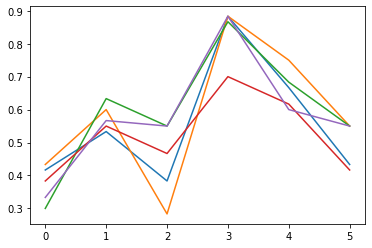

In [19]:
results = np.array([[0.41666667,0.43333333,0.3,0.38333333,0.33333333],
            [0.53333333,0.6,0.63333333,0.55,0.56666667],
            [0.38333333,0.28333333,0.55,0.46666667,0.55],
            [0.88333333,0.88333333,0.86666667,0.7,0.88333333],
            [0.66666667,0.75,0.68333333,0.61666667,0.6],
            [0.43333333,0.55,0.55,0.41666667,0.55]])
plt.plot(results)
plt.show()

In [29]:
#print(results[0,:])
for row in results:
    mean = np.mean(row)
    std = np.std(row)
    print(f"{mean}\t{std}")

0.37333333199999996	0.050110988105293804
0.576666666	0.03590109828094098
0.44666666599999993	0.10241527824391139
0.843333332	0.0719567762541437
0.663333334	0.05312459070692013
0.5	0.06146362953451059
0.5672222216666667	0.16746936339868407	0.028045987677160506	[0.28333333 0.43333333 0.55       0.65833334 0.88333333]
